# Implementing AutoML (H20)
- modeltype: **AutoML** (H20)
- train: **0.912**
- test: **0.860**

Note: TPOT has been implemented in another notebook

I have chosen Auto ML for part three as I was curious about autoML and have been reading about it over the internet for the past few weeks. Thus wanted to get my hands on it.

## Flow of the notebook
* 1. Reading Data and importing libraries
* 2. Data Manipulation
* 3. Implementing AutoML

## 1. Reading Data & Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import pickle


import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch


from h2o.automl import H2OAutoML

from category_encoders import *

In [2]:
# ! pip install category-encoders

In [3]:
# Set directories
print(os.getcwd())
dirRawData = "../input/"
dirPData   = "../PData/"
dirPOutput = "../POutput/"

/home/jovyan/Final_Project/Pcode


In [4]:
f_name = dirPData + '01_df_250k.pickle'

with (open(f_name, "rb")) as f:
    dict_ = pickle.load(f)

df_train = dict_['df_train']
df_test  = dict_['df_test']

del f_name, dict_

In [5]:
f_name = dirPData + '01_vars.pickle'

with open(f_name, "rb") as f:
    dict_ = pickle.load(f)

vars_ind_numeric     = dict_['vars_ind_numeric']
vars_ind_hccv        = dict_['vars_ind_hccv']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_notToUse        = ['unique_id']
var_dep              = dict_['var_dep']

del f_name, dict_

## 2. Data Manipulation

### Splines

Since AutoML also explores GLM, I incuded splines to make the model more efficient.

Splines have been created for three varibales ['f02', 'f11', 'f13'].
I ran a Random Forest algorithm considering only numeric variables to see which all numeric variables are the most important.
I did not want to make splines on all numeric variables as it may decrease my speed exponentially by only giving a slightly 
better accuracy.

For running the random forest, I made a "Sample" dataframe and removed -99 (NAs). I have treated -99 on train and test dataframe
afterwards through H20. The reason why I did not treat NAs right now was because few of NAs are being taken as NAs in H20 while few of them were 
been taken as "NA" (String) which was strange. Therefore I treated all NAs in H20 only.

Also, I did not standarised the variables, because Random Forest (for splines) do not require standarise variables 
while H20 will automatically treat them while doing Logistic Regression.

I have run the spline function on test as "fn_tosplines(df_test[var])" becasue what I feels is, in real life scenario, we
wouldn't be having the test frame and therfore have to use the pre-decided variables and percentile values on test frame.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Feature: 0, Score: 0.03598
Feature: 1, Score: 0.00165
Feature: 2, Score: 0.00343
Feature: 3, Score: 0.00099
Feature: 4, Score: 0.00172
Feature: 5, Score: 0.00393
Feature: 6, Score: 0.00128
Feature: 7, Score: 0.01668
Feature: 8, Score: 0.02994
Feature: 9, Score: 0.04107
Feature: 10, Score: 0.04188
Feature: 11, Score: 0.01643
Feature: 12, Score: 0.02677
Feature: 13, Score: 0.02518
Feature: 14, Score: 0.03268
Feature: 15, Score: 0.00675
Feature: 16, Score: 0.01379
Feature: 17, Score: 0.05130
Feature: 18, Score: 0.04107
Feature: 19, Score: 0.04940
Feature: 20, Score: 0.02491
Feature: 21, Score: 0.00312
Feature: 22, Score: 0.02837
Feature: 23, Score: 0.02781
Feature: 24, Score: 0.05278
Feature: 25, Score: 0.04322
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.02230
Feature: 28, Score: 0.02919
Feature: 29, Score: 0.10226
Feature: 30, Score: 0.01353
Feature: 31, Score: 0.00134
Feature: 32, Score: 0.07993
Feature: 33, Score: 0.07176
Feature: 34, Score: 0.01039
Feature: 35, Score: 0.00658
Fe

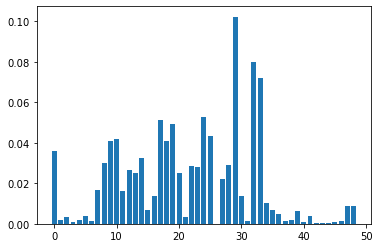

In [61]:
######## The Following is the code that gave us most important numeric feature through Random Forest ########

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

sample = df_train.copy() 
sample = sample.replace(-99, np.nan)
sample = sample.dropna()

# random forest for feature importance on a classification problem
# define dataset
X, y = sample[[var for var in vars_ind_numeric if var not in vars_notToUse]], np.array(sample[var_dep])
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

high_imprtance_num_var = list(X.columns)
high_imprtance_num_var  = [high_imprtance_num_var [i] for i in [29,32,33]]

################## END ##################

In [7]:
high_imprtance_num_var = ['f02', 'f11', 'f13']

In [8]:
vars_ind_tospline = high_imprtance_num_var

def fn_tosplines(x):
    x = x.values
    # hack: remove zeros to avoid issues where lots of values are zero
    x_nonzero = x[x != 0]
    ptiles = np.percentile(x_nonzero, [10, 20, 40, 60, 80, 90])
    #print(var, ptiles)
    df_ptiles = pd.DataFrame({var: x})
    for idx, ptile in enumerate(ptiles):
        df_ptiles[var + '_' + str(idx)] = np.maximum(0, x - ptiles[idx])
    return(df_ptiles)

for var in vars_ind_tospline:
    df_ptiles = fn_tosplines(df_train[var])
    df_train.drop(columns=[var], inplace=True)
    vars_ind_numeric.remove(var)
    df_train = pd.concat([df_train, df_ptiles], axis=1, sort=False)
    vars_ind_numeric.extend(df_ptiles.columns.tolist())

In [9]:
for var in vars_ind_tospline:
    df_ptiles_t = fn_tosplines(df_train[var])  # here we use the same ptiles as for train to spline the same way
    df_test.drop(columns=[var], inplace=True)
    # vars_ind_numeric_test.remove(var)
    df_test = pd.concat([df_test, df_ptiles_t], axis=1, sort=False)
    # vars_ind_numeric_test.extend(df_ptiles_t.columns.tolist())

### NAs

As discussed in earlier questions, H20 takes care of missing values in both GLM and XGBoost method therefore here we are only deleting variable 'c02' since it has >50% NAs in test data. -99 values will be treated in the H20 Frame.

In [11]:


# Since C02 has a lot of NAs (>50%), we will drop it from both train and test
df_test.drop('c02', axis=1, inplace = True)
df_train.drop('c02', axis=1, inplace = True)
vars_ind_categorical.remove('c02')


### 2.3 Cardinality
   For treating the hccv we have used Target Encoders (Sk-Learn). We have also observed that there is oversampling of few factors 
    while others are under-sampled therefore we have used smoothing factor = 4. Smoothing of 4 is chosen by following few online 
    blogs. Also scikit learn is used to do the target encoding because I was a bit confused with H20 target encoding. Additionally,
    H20 automatically perform one_hot encoding on categorical variables so they have not been treated.


Note: I needed to update the scikit-learn and category_ecoders library

In [8]:
# To see the distribution of factors in a hcc variable
# df_train[vars_ind_hccv].nunique()
# df_train['e18'].value_counts()

In [6]:
# Target encoders on Train
enc = TargetEncoder(cols=vars_ind_hccv, smoothing =4)
enc.fit_transform(df_train, df_train['target'])
df_train = enc.transform(df_train, df_train['target'])

In [7]:
# Target encoders on Test
df_test['target'] = np.nan # Creating dummy 'target' variable for using the the enc.transform function
df_test = enc.transform(df_test) # applying the already trained encoder
df_test.drop(columns=['target'], inplace=True) # Dropping dummy 'target' variable

Running H20 cluster

In [16]:
h2o.cluster().shutdown()

AttributeError: 'NoneType' object has no attribute 'shutdown'

In [15]:
h2o.init(port=54321, max_mem_size = "14g") # Asking h20 to use 14 GB of Ram
h2o.connect()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 24 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,"1 year, 2 months and 8 days !!!"
H2O cluster name:,H2O_from_python_jovyan_s0rtq1
H2O cluster total nodes:,1
H2O cluster free memory:,12.24 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O cluster uptime:,1 hour 24 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,"1 year, 2 months and 8 days !!!"
H2O cluster name:,H2O_from_python_jovyan_s0rtq1
H2O cluster total nodes:,1
H2O cluster free memory:,12.24 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


<H2OConnection to http://localhost:54321, no session>

We have removed 'unique_id' from Frames as it was not useful in prediction


In [9]:
vars_to_use = vars_ind_numeric + vars_ind_categorical
vars_to_use.remove('unique_id')
vars_ind_numeric.remove('unique_id')


h2o_df_train = h2o.H2OFrame(df_train[[var for var in vars_to_use+var_dep ]], destination_frame = 'df_train') # Train Frame
h2o_df_test  = h2o.H2OFrame(df_test[[var for var in vars_to_use]], destination_frame = 'df_test') # Test Frame

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Converting -99 to NAs. We have not done this before becuase as discussed earlier, converting pandas NAs to H20 Frame were not consistent and was giving an error (may be due to the older version of H20 in the image).

In [10]:
# Converting -99 to NA in train
for var in vars_ind_numeric:
    h2o_df_train[h2o_df_train[var] == -99.0 , var] = None
    
# Converting -99 to NA in test
for var in vars_ind_numeric:
    h2o_df_test[h2o_df_test[var] == -99.0 , var] = None

In [11]:
# H20 Document suggest to make dependant variable as factor for classiication task
h2o_df_train[var_dep] = h2o_df_train[var_dep].asfactor()

### 2.4 Interactions
Documentation regarding the interaction in XGBoost was not clear, therefore after  searching for online, especially [here](https://www.kaggle.com/c/bosch-production-line-performance/discussion/24418) making interaction seemed to be a logical choice given it has drastically improved the past model (GLM) performance.

I have not used the interaction on all variables, instead I have used it only on 2 variables ('f03' and 'e11'). These two 
variables have been chosen after running GLM model and then calculating variables importance.
I did not use all categorical variables, as it could not improve the performance significantly but made the
model quite complex to comprehend. Therefore, it was a trade-off between accuracy and complexity.


In [44]:
# Code for runing GLM to see which all variables are important

# Idea has been taken from: https://aichamp.wordpress.com/2017/09/29/python-example-of-building-glm-gbm-and-random-forest-
# binomial-model-with-h2o/


# from h2o.estimators.glm import H2OGeneralizedLinearEstimator
# glm_logistic = H2OGeneralizedLinearEstimator(family = "binomial")
# glm_logistic.train(x=vars_to_use , y= 'target', training_frame=h2o_df_train, model_id="glm_logistic")
# preds = glm_logistic.predict(h2o_df_test)
# df_test['Predicted'] = np.round(preds[2].as_data_frame(), 5)
# df_preds_dt = df_test[['unique_id', 'Predicted']].copy()
# df_test[['unique_id', 'Predicted']].to_csv(dirPOutput + '1st.csv', index=False)
# log_var_imp = glm_logistic.varimp(use_pandas=True).head()
# log_var_imp.loc[0:5, 'variable'].tolist()

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e20' has levels not trained on: [30146, BE271, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e13' has levels not trained on: [Q, S]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e24' has levels not trained on: [J, M, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e03' has levels not trained on: [J, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'c09' has levels not trained on: [nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'a18' has levels not trained on: [D]
  warnings.warn(w)


['f10', 'f03.F', 'e19', 'e11.A', 'f03.E']

I have chosen min_occurence as int(len(h2o_df_train)/40) after many trial and error.

With int(len(h2o_df_train)/40) on 250K train data I was getting 5 factors for each variable. I believe performing 
interactions on top 4-5 variables rather than all the variables having occurrence > 10/20 would make the model
faster and more interpretable

In [12]:
# Train Frame
interaction_frame_train = h2o_df_train.interaction(['f03', 'e11'], pairwise = False, max_factors = 100,
                                                   min_occurrence = int(len(h2o_df_train)/40))

# Test Frame
interaction_frame_test = h2o_df_test.interaction(['f03', 'e11'], pairwise = False, max_factors = 100, 
                                                 min_occurrence = int(len(h2o_df_train)/40))

# Cbinding interaction frame to train and test
h2o_df_train = h2o_df_train.cbind(interaction_frame_train)
h2o_df_test = h2o_df_test.cbind(interaction_frame_test)

Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%


In [13]:
# incuding interaction frame's variable to variables list
vars_to_use = vars_to_use + ['f03_e11']
vars_ind_numeric = vars_ind_numeric + ['f03_e11']

In [27]:
# Saving this data to be used for TPOT analysis

train_for_TPOT = h2o.as_list(h2o_df_train)
test_for_TPOT = h2o.as_list(h2o_df_test)

dict_ = {'df_train': train_for_TPOT,
         'df_test': test_for_TPOT}

f_name = dirPData + 'TPOT_DB.pickle'
with open(f_name, "wb") as f:
    pickle.dump(dict_, f)
del f_name, dict_

# store variable names to pickle
dict_ = {'vars_ind_numeric': vars_ind_numeric,
         'vars_to_use': vars_to_use,
         'var_dep': var_dep}

f_name = dirPData + 'TPOT_VARS.pickle'
with open(f_name, "wb") as f:
    pickle.dump(dict_, f)
del f_name, dict_

## 3. Implementing AutoML in H20

### 3.1 How it works?


AutoML performs three tasks, i.e. data preparation, model generation and Ensembles.

**Data preparation** task includes mean imputing the missing values, standarising variables (therefore we have not standarised the variables in our data preparation task), one-hot encoding categorical features and features extraction (e.g. PCA).


**model generation**: AutoML trains and cross-validates the following algorithms (in the following order): three pre-specified XGBoost GBM (Gradient Boosting Machine) models, a fixed grid of GLMs, a default Random Forest (DRF), five pre-specified H2O GBMs, a near-default Deep Neural Net, an Extremely Randomized Forest (XRT), a random grid of XGBoost GBMs, a random grid of H2O GBMs, and a random grid of Deep Neural Nets. In some cases, there will not be enough time to complete all the algorithms, so some may be missing from the leaderboard. This [source](https://www.slideshare.net/0xdata/intro-to-automl-handson-lab-erin-ledell-machine-learning-scientist-h2oai) also states that it uses Bayesian hyperparameter optimisation, but I couldn't find in the documentation as on which algorithm it actually uses this.


**Ensembles**:Ensembles train Two Stacked models. One ensemble contains all the models, and the other ensemble provides just the best performing model from each algorithm class/family.



### Parameters of the algorithm


* project_name: setting a name will enable us to train additional data on the same AutoML project
* nfolds : H20 Documentation [here](https://www.slideshare.net/0xdata/scalable-automatic-machine-learning-in-h2o-89130971) suggest not to use leaderboard frame (validation set) unless it is necessary and suggest to go for the default method of nfolds where nfold = 5 and take 20% of the data.
* exclude_algos: list of algorithm to exclude. We have not provided any value to it
* balance_class: Specify whether to oversample the minority classes to balance the class distribution. But in our data, are balanced with both 0 and 1 having around 12,000 occurrence.

The official document states "The H2O AutoML interface is designed to have as few parameters as possible so that all the user needs to do is point to their dataset, identify the response column and optionally specify a time constraint or limit on the number of total models trained." Therefore, there are not many parameters to optimise. few of the parameters are discussed in the code as well.



### Hyper-parameters of GLM and XGBoost algorithm

* **GLM**: AutoML does not run a grid search for GLM. Instead AutoML builds a single model with lambda_search enabled and passes a list of alpha values. It returns only the model with the best alpha-lambda combination rather than one model for each alpha. alpha = {0.0, 0.2, 0.4, 0.6, 0.8, 1.0}. *Part 1 showed us that alpha value of 0.92 works well with our data but it is likely to be excluded in this.*

* **XGBoost**: AutoML takes a variety of hyper parameters such as 'col_sample_rate', 'col_sample_rate_per_tree', 'max_depth', 'min_rows' etc. for random grid search but ntrees are set to be 10,000. This is quite odd and I didn't find the reason why they do it. Also I couldnt find the what value of learn_rate does this model takes.

### 3.2 Implementing the algorithm

In [21]:
# To check if XGBoost is availbale. If its not then AutoML wont condier it
h2o.estimators.xgboost.H2OXGBoostEstimator.available()

True

In [56]:
# See if balance class is required
h2o_df_train['target'].table()

target,Count
0,127169
1,122831


In [22]:
# Identify predictors and response
x = h2o_df_train.columns
y = "target"
x.remove(y)

In [23]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20,
                seed=2020, # setting the seeds are actually not recommended in the documentation, stating it will re-gerate
                # the same result again, but here this is what we actually wants. By defaut is sets the sees randomly.
                max_runtime_secs = 5400, # This argument specifies the maximum time that the AutoML process will run for,
                # prior to training the final Stacked Ensemble models.
                stopping_metric = 'AUC', # Auto is also equal to AUC
                stopping_rounds = 3 # default
                , exclude_algos = None
                , export_checkpoints_dir = '/home/jovyan/Final_Project/PData')


aml.train(x=x, y=y, training_frame=h2o_df_train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [24]:
# Viewing the algorithm result
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)
#lb_all_columns = .get_leaderboard(aml, extra_columns = 'ALL')

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200715_111507,0.881305,0.436847,0.210478,0.376244,0.141559
StackedEnsemble_BestOfFamily_AutoML_20200715_111507,0.881037,0.437242,0.211918,0.376418,0.141691
GBM_5_AutoML_20200715_111507,0.878721,0.434454,0.217896,0.376662,0.141874
XGBoost_1_AutoML_20200715_111507,0.878474,0.437477,0.214002,0.377522,0.142523
XGBoost_2_AutoML_20200715_111507,0.87813,0.445032,0.215206,0.379171,0.143771
GBM_4_AutoML_20200715_111507,0.878104,0.435602,0.216831,0.377158,0.142248
GBM_3_AutoML_20200715_111507,0.878045,0.435899,0.214013,0.377295,0.142351
GBM_2_AutoML_20200715_111507,0.87687,0.437741,0.216873,0.378297,0.143109
GBM_1_AutoML_20200715_111507,0.876527,0.437983,0.216694,0.378517,0.143275
DeepLearning_1_AutoML_20200715_111507,0.874498,0.44315,0.218672,0.379649,0.144133


In [25]:
# H20 Documentation says: To generate predictions on a test set, you can make predictions
# directly on the `"H2OAutoML"` object or on the leader model
# object directly

preds = aml.leader.predict(h2o_df_test)
df_test['Predicted'] = np.round(preds[2].as_data_frame(), 5)
df_preds_dt = df_test[['unique_id', 'Predicted']].copy()
df_test[['unique_id', 'Predicted']].to_csv(dirPOutput + 'AutoML_test)final.csv', index=False)

# Kaggle socre = 0.860

stackedensemble prediction progress: |████████████████████████████████████| 100%


/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'a18' has levels not trained on: [D]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'c09' has levels not trained on: [nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e03' has levels not trained on: [J, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e13' has levels not trained on: [Q, S]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e24' has levels not trained on: [J, M, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e20' has levels not trained on: [30146, BE271, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o

In [31]:
# Exploring the leader algorithm
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20200715_111507
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.12175295314952604
RMSE: 0.3489311581809885
LogLoss: 0.3851042301810654
Null degrees of freedom: 249999
Residual degrees of freedom: 249993
Null deviance: 346498.31352617935
Residual deviance: 192552.1150905327
AIC: 192566.1150905327
AUC: 0.9118278376117468
pr_auc: 0.9043886914211718
Gini: 0.8236556752234936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43304635798588603: 


,0,1,Error,Rate
0,98520.0,28649.0,0.2253,(28649.0/127169.0)
1,16089.0,106742.0,0.131,(16089.0/122831.0)
Total,114609.0,135391.0,0.179,(44738.0/250000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4330464,0.8267460,225.0
max f2,0.1747967,0.8926100,327.0
max f0point5,0.6806546,0.8359927,128.0
max accuracy,0.5157484,0.825052,193.0
max precision,0.9417606,1.0,0.0
max recall,0.0527699,1.0,396.0
max specificity,0.9417606,1.0,0.0
max absolute_mcc,0.5128156,0.6500095,194.0
max min_per_class_accuracy,0.5128156,0.8242952,194.0
max mean_per_class_accuracy,0.5128156,0.8250273,194.0


Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9380719,2.0345027,2.0345027,0.9996,0.9398565,0.9996,0.9398565,0.0203450,0.0203450,103.4502691,103.4502691
,2,0.02,0.9358555,2.0345027,2.0345027,0.9996,0.9369448,0.9996,0.9384006,0.0203450,0.0406901,103.4502691,103.4502691
,3,0.03,0.9338231,2.0296179,2.0328744,0.9972,0.9348207,0.9988,0.9372073,0.0202962,0.0609862,102.9617930,103.2874437
,4,0.04,0.9318135,2.0263614,2.0312462,0.9956,0.9328115,0.998,0.9361083,0.0202636,0.0812498,102.6361423,103.1246184
,5,0.05,0.9298782,2.0182202,2.0286410,0.9916,0.9308554,0.99672,0.9350577,0.0201822,0.1014320,101.8220156,102.8640978
,6,0.1,0.9183842,2.0030774,2.0158592,0.98416,0.9245022,0.99044,0.9297800,0.1001539,0.2015859,100.3077399,101.5859189
,7,0.15,0.9015113,1.9537413,1.9951532,0.95992,0.9104151,0.9802667,0.9233250,0.0976871,0.2992730,95.3741319,99.5153232
,8,0.2,0.8773822,1.8860060,1.9678664,0.92664,0.8901701,0.96686,0.9150363,0.0943003,0.3935733,88.6005976,96.7866418
,9,0.3,0.7960703,1.7187843,1.8848391,0.84448,0.8411968,0.9260667,0.8904231,0.1718784,0.5654517,71.8784346,88.4839061
,10,0.4,0.6580722,1.4611132,1.7789076,0.71788,0.7307381,0.87402,0.8505018,0.1461113,0.7115630,46.1113237,77.8907605




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1415594170010771
RMSE: 0.37624382652885763
LogLoss: 0.43684731351716816
Null degrees of freedom: 249999
Residual degrees of freedom: 249993
Null deviance: 346499.73038801143
Residual deviance: 218423.65675858408
AIC: 218437.65675858408
AUC: 0.8813045721676378
pr_auc: 0.86987658922156
Gini: 0.7626091443352756
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3815157721554832: 


,0,1,Error,Rate
0,91038.0,36131.0,0.2841,(36131.0/127169.0)
1,16808.0,106023.0,0.1368,(16808.0/122831.0)
Total,107846.0,142154.0,0.2118,(52939.0/250000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3815158,0.8002189,247.0
max f2,0.1340032,0.8783951,347.0
max f0point5,0.6787119,0.8031552,130.0
max accuracy,0.4914044,0.792884,204.0
max precision,0.9382808,0.9918490,2.0
max recall,0.0504010,1.0,399.0
max specificity,0.9411686,0.9999450,0.0
max absolute_mcc,0.4334173,0.5871186,226.0
max min_per_class_accuracy,0.5085504,0.7920405,197.0
max mean_per_class_accuracy,0.4653819,0.7933155,214.0


Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.13 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9373213,2.0182202,2.0182202,0.9916,0.9392147,0.9916,0.9392147,0.0201822,0.0201822,101.8220156,101.8220156
,2,0.02,0.9350389,2.0141495,2.0161848,0.9896,0.9361284,0.9906,0.9376716,0.0201415,0.0403237,101.4149523,101.6184839
,3,0.03,0.9329862,2.0100789,2.0141495,0.9876,0.9340292,0.9896,0.9364575,0.0201008,0.0604245,101.0078889,101.4149523
,4,0.04,0.9310474,1.9832127,2.0064153,0.9744,0.9320226,0.9858,0.9353487,0.0198321,0.0802566,98.3212707,100.6415319
,5,0.05,0.9289912,1.9840268,2.0019376,0.9748,0.9300316,0.9836,0.9342853,0.0198403,0.1000969,98.4026834,100.1937622
,6,0.1,0.9174043,1.9420179,1.9719778,0.95416,0.9235560,0.96888,0.9289206,0.0971009,0.1971978,94.2017895,97.1977758
,7,0.15,0.9003844,1.8710260,1.9383272,0.91928,0.9094049,0.9523467,0.9224154,0.0935513,0.2907491,87.1026044,93.8327187
,8,0.2,0.8766146,1.7844030,1.8998461,0.87672,0.8891793,0.93344,0.9141064,0.0892201,0.3799692,78.4402960,89.9846130
,9,0.3,0.7967872,1.6311029,1.8102651,0.8014,0.8409726,0.8894267,0.8897285,0.1631103,0.5430795,63.1102897,81.0265053
,10,0.4,0.6599767,1.4006236,1.7078547,0.68816,0.7321379,0.83911,0.8503308,0.1400624,0.6831419,40.0623621,70.7854695


### 3.3 Best Ensemble Exploration

To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model. The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run. This is the top performing model on the leaderboard.

In [26]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

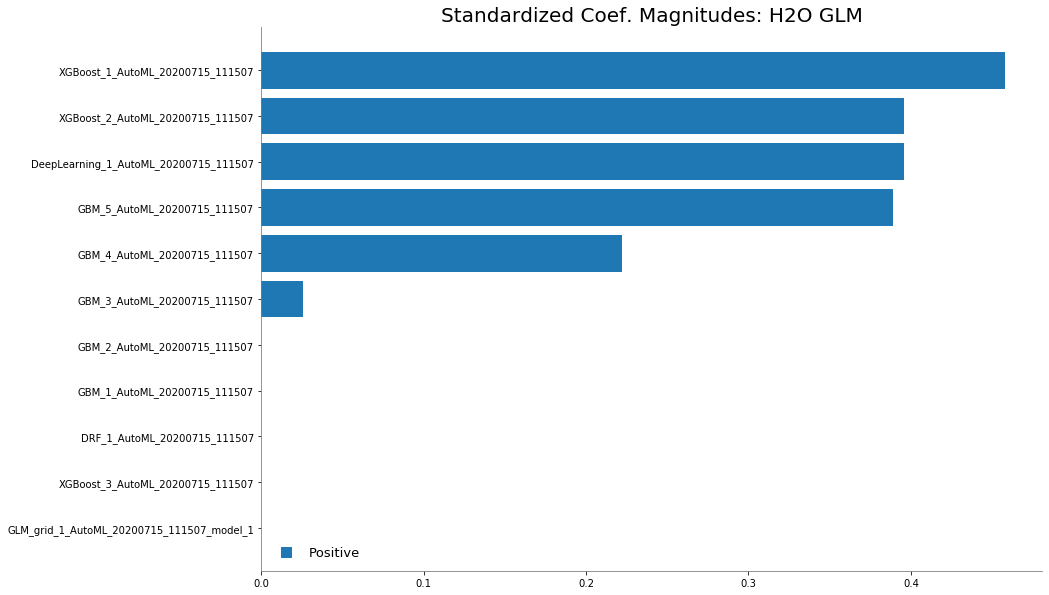

In [27]:
%matplotlib inline
metalearner.std_coef_plot()

The plot shows us that XGboost followed by Deeplearning and GBM had the most weightage for our algorithm. Co-efficient of GLM is nearly zero. 

In [28]:
metalearner

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20200715_111507


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1415503771610387
RMSE: 0.3762318130634871
LogLoss: 0.4368127330232597
Null degrees of freedom: 249999
Residual degrees of freedom: 249993
Null deviance: 346498.31352617935
Residual deviance: 218406.36651162984
AIC: 218420.36651162984
AUC: 0.8813244532896827
pr_auc: 0.8705021026355652
Gini: 0.7626489065793653
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38303101077885854: 


,0,1,Error,Rate
0,91135.0,36034.0,0.2834,(36034.0/127169.0)
1,16883.0,105948.0,0.1374,(16883.0/122831.0)
Total,108018.0,141982.0,0.2117,(52917.0/250000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3830310,0.8001722,246.0
max f2,0.1358440,0.8785517,346.0
max f0point5,0.6834284,0.8031449,130.0
max accuracy,0.4946793,0.793016,205.0
max precision,0.9415145,0.9928058,0.0
max recall,0.0502724,1.0,399.0
max specificity,0.9415145,0.9999764,0.0
max absolute_mcc,0.4485215,0.5871245,222.0
max min_per_class_accuracy,0.5088997,0.7925117,199.0
max mean_per_class_accuracy,0.4657949,0.7932980,216.0


Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.13 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9374579,2.0182202,2.0182202,0.9916,0.9393201,0.9916,0.9393201,0.0201822,0.0201822,101.8220156,101.8220156
,2,0.02,0.9351675,2.0141495,2.0161848,0.9896,0.9362495,0.9906,0.9377848,0.0201415,0.0403237,101.4149523,101.6184839
,3,0.03,0.9331187,2.0125213,2.0149636,0.9888,0.9341549,0.99,0.9365748,0.0201252,0.0604489,101.2521269,101.4963649
,4,0.04,0.9311676,1.9807703,2.0064153,0.9732,0.9321391,0.9858,0.9354659,0.0198077,0.0802566,98.0770327,100.6415319
,5,0.05,0.9291373,1.9848410,2.0021004,0.9752,0.9301513,0.98368,0.9344030,0.0198484,0.1001050,98.4840960,100.2100447
,6,0.1,0.9175390,1.9420179,1.9720592,0.95416,0.9236772,0.96892,0.9290401,0.0971009,0.1972059,94.2017895,97.2059171
,7,0.15,0.9004814,1.8713517,1.9384900,0.91944,0.9095370,0.9524267,0.9225391,0.0935676,0.2907735,87.1351695,93.8490012
,8,0.2,0.8767634,1.7834260,1.8997240,0.87624,0.8893168,0.93338,0.9142335,0.0891713,0.3799448,78.3426008,89.9724011
,9,0.3,0.7969135,1.6327312,1.8107264,0.8022,0.8411107,0.8896533,0.8898592,0.1632731,0.5432179,63.2731151,81.0726391
,10,0.4,0.6601018,1.3999723,1.7080379,0.68784,0.7322576,0.8392,0.8504588,0.1399972,0.6832151,39.9972320,70.8037873




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.1415594170010771
RMSE: 0.37624382652885763
LogLoss: 0.43684731351716816
Null degrees of freedom: 249999
Residual degrees of freedom: 249993
Null deviance: 346499.73038801143
Residual deviance: 218423.65675858408
AIC: 218437.65675858408
AUC: 0.8813045721676378
pr_auc: 0.86987658922156
Gini: 0.7626091443352756
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3815157721554832: 


,0,1,Error,Rate
0,91038.0,36131.0,0.2841,(36131.0/127169.0)
1,16808.0,106023.0,0.1368,(16808.0/122831.0)
Total,107846.0,142154.0,0.2118,(52939.0/250000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3815158,0.8002189,247.0
max f2,0.1340032,0.8783951,347.0
max f0point5,0.6787119,0.8031552,130.0
max accuracy,0.4914044,0.792884,204.0
max precision,0.9382808,0.9918490,2.0
max recall,0.0504010,1.0,399.0
max specificity,0.9411686,0.9999450,0.0
max absolute_mcc,0.4334173,0.5871186,226.0
max min_per_class_accuracy,0.5085504,0.7920405,197.0
max mean_per_class_accuracy,0.4653819,0.7933155,214.0


Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.13 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9373213,2.0182202,2.0182202,0.9916,0.9392147,0.9916,0.9392147,0.0201822,0.0201822,101.8220156,101.8220156
,2,0.02,0.9350389,2.0141495,2.0161848,0.9896,0.9361284,0.9906,0.9376716,0.0201415,0.0403237,101.4149523,101.6184839
,3,0.03,0.9329862,2.0100789,2.0141495,0.9876,0.9340292,0.9896,0.9364575,0.0201008,0.0604245,101.0078889,101.4149523
,4,0.04,0.9310474,1.9832127,2.0064153,0.9744,0.9320226,0.9858,0.9353487,0.0198321,0.0802566,98.3212707,100.6415319
,5,0.05,0.9289912,1.9840268,2.0019376,0.9748,0.9300316,0.9836,0.9342853,0.0198403,0.1000969,98.4026834,100.1937622
,6,0.1,0.9174043,1.9420179,1.9719778,0.95416,0.9235560,0.96888,0.9289206,0.0971009,0.1971978,94.2017895,97.1977758
,7,0.15,0.9003844,1.8710260,1.9383272,0.91928,0.9094049,0.9523467,0.9224154,0.0935513,0.2907491,87.1026044,93.8327187
,8,0.2,0.8766146,1.7844030,1.8998461,0.87672,0.8891793,0.93344,0.9141064,0.0892201,0.3799692,78.4402960,89.9846130
,9,0.3,0.7967872,1.6311029,1.8102651,0.8014,0.8409726,0.8894267,0.8897285,0.1631103,0.5430795,63.1102897,81.0265053
,10,0.4,0.6599767,1.4006236,1.7078547,0.68816,0.7321379,0.83911,0.8503308,0.1400624,0.6831419,40.0623621,70.7854695



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.7857159,0.0021270,0.7879333,0.7812162,0.7851982,0.7842972,0.7899345
auc,0.8813058,0.0008034,0.8812296,0.8801973,0.8827597,0.8799323,0.8824099
err,0.2142841,0.0021270,0.2120667,0.2187838,0.2148018,0.2157028,0.2100655
err_count,10714.2,107.60428,10608.0,10923.0,10791.0,10764.0,10485.0
f0point5,0.7615901,0.0032423,0.7656216,0.754774,0.7600142,0.7598704,0.7676703
---,---,---,---,---,---,---,---
r2,0.4335817,0.0018254,0.4331871,0.4312677,0.4371522,0.4304407,0.4358610
recall,0.8754463,0.0071936,0.8654175,0.8863664,0.8835772,0.8807038,0.8611669
residual_deviance,43684.73,92.08617,43718.13,43782.633,43653.65,43819.164,43450.082
rmse,0.3762443,0.0006124,0.3763709,0.3770163,0.3750747,0.3773107,0.3754489



See the whole table with table.as_data_frame()
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2020-07-15 12:45:33,0.000 sec,0,173249.1567631,0.6929966
,2020-07-15 12:45:33,0.103 sec,1,113005.5595574,0.4525288
,2020-07-15 12:45:33,0.153 sec,2,109345.7864279,0.4380721
,2020-07-15 12:45:33,0.208 sec,3,109203.9393470,0.4375531
,2020-07-15 12:45:33,0.259 sec,4,109203.1832558,0.4375520
